In [ ]:
import os
from lwt import get_key
os.environ["TRACE_DEFAULT_LLM_BACKEND"] = "LiteLLM"

# 2) Set your OpenAI key
os.environ["OPENAI_API_KEY"] = get_key()

# 3) Tell Trace + LiteLLM which model to use by default
os.environ["TRACE_LITELLM_MODEL"] = "gpt-5-mini"
# os.environ["TRACE_LITELLM_MODEL"] = "gpt-5-nano"
os.environ["LITELLM_LOG"] = "INFO"

In [25]:
from opto.trace import node, bundle

@bundle(trainable=True)
def comment_strange_sort_list(lst):
    '''
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.

    Examples:
    strange_sort_list([1, 2, 3, 4]) == [1, 4, 2, 3]
    strange_sort_list([5, 5, 5, 5]) == [5, 5, 5, 5]
    strange_sort_list([]) == []
    '''
    lst = sorted(lst)
    return lst

@bundle(trainable=True)
def strange_sort_list(lst):
    lst = sorted(lst)
    return lst

test_input = [1, 2, 3, 4]
test_output = strange_sort_list(test_input)
print(test_output)

MessageNode: (eval:10, dtype=<class 'list'>, data=[1, 2, 3, 4])


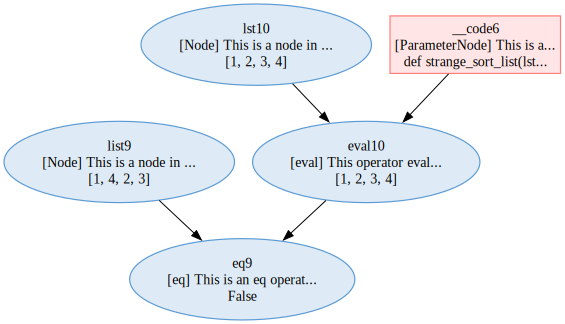

In [26]:
correctness = test_output.eq([1, 4, 2, 3])
correctness.backward("test failed", visualize=True, print_limit=25)

In [27]:
def get_feedback(predict, target):
    if predict == target:
        return "test case passed!"
    else:
        return "test case failed!"

In [34]:
import autogen
from opto.optimizers import OptoPrime
from opto import trace

test_ground_truth = [1, 4, 2, 3]
test_input = [1, 2, 3, 4]

epoch = 5
print('building optimizer')
optimizer = OptoPrime(strange_sort_list.parameters())

for i in range(epoch):
    print(f"Training Epoch {i}")
    try:
        test_output = strange_sort_list(test_input)
        feedback = get_feedback(test_output, test_ground_truth)
    except trace.ExecutionError as e:
        feedback = e.exception_node.data
        test_output = e.exception_node
    
    correctness = test_output.eq(test_ground_truth)
    
    if correctness:
        break

    optimizer.zero_feedback()
    optimizer.backward(correctness, feedback)
    optimizer.step(verbose=True)

building optimizer
Training Epoch 0


In [33]:
from opto.trace.utils import render_opt_step

render_opt_step(0, optimizer)

IndexError: list index out of range

In [35]:
print(strange_sort_list.parameters()[0].data)


def strange_sort_list(lst):
    # Build a new list by repeatedly taking the first then the last element
    res = []
    tmp = list(lst)
    while tmp:
        res.append(tmp.pop(0))
        if tmp:
            res.append(tmp.pop(-1))
    return res



In [31]:
step = 0
print(optimizer.log[step].keys())
print("RESPONSE RAW:\n", repr(optimizer.log[step].get("response")))

dict_keys(['system_prompt', 'user_prompt', 'response'])
RESPONSE RAW:
 '{\n"reasoning": "The instruction asks to change the values of variables in #Variables to improve the output per the feedback. The feedback says \\"test case failed!\\" — looking at the execution, eval11 is produced by calling __code6 on lst11. Currently __code6 sorts the list, so eval11 becomes [1, 2, 3, 4]. eq10 compares eval11 with list10 ([1, 4, 2, 3]) and returns False, causing the test failure. To make the test pass, eval11 must match list10. Therefore __code6 should be changed so that strange_sort_list([1,2,3,4]) returns [1,4,2,3]. A simple, general approach is to build a new list by repeatedly taking the first element then the last element from a copy of the input list — that produces [1,4,2,3] for the given input and will make eq10 True.",\n"answer": "Modify __code6 so strange_sort_list reorders the list by taking first, then last, repeatedly. This will make eval11 equal to list10 and eq10 True.",\n"suggest